### 构建卷积神经网络
- 卷积网络中的输入和层与传统神经网络有些区别，需重新设计，训练模块基本一致

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### 首先读取数据
- 分别构建训练集和测试集（验证集）
- DataLoader来迭代取数据

In [17]:
# 定义超参数 
input_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 3  #训练的总循环周期
batch_size = 64  #一个撮（批次）的大小，64张图片

# 训练集
train_dataset = datasets.MNIST(root='./data',  
                            train=True,   
                            transform=transforms.ToTensor(),  
                            download=True) 

# 测试集
test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 构建batch数据
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

### 卷积网络模块构建
- 一般卷积层，relu层，池化层可以写成一个套餐
- 注意卷积最后结果还是一个特征图，需要把图转换成向量才能做分类或者回归任务

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # 输入大小 (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # 灰度图
                out_channels=16,            # 要得到几多少个特征图
                kernel_size=5,              # 卷积核大小
                stride=1,                   # 步长
                padding=2,                  # 如果希望卷积后大小跟原来一样，需要设置padding=(kernel_size-1)/2 if stride=1
            ),                              # 输出的特征图为 (16, 28, 28)
            nn.ReLU(),                      # relu层
            nn.MaxPool2d(kernel_size=2),    # 进行池化操作（2x2 区域）, 输出结果为： (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # 下一个套餐的输入 (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # 输出 (32, 14, 14)
            nn.ReLU(),                      # relu层
            nn.MaxPool2d(2),                # 输出 (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # 全连接层得到的结果

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten操作，结果为：(batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

### 准确率作为评估标准

In [19]:
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    return rights, len(labels) 

### 训练网络模型

In [20]:
# 实例化
net = CNN() 
#损失函数
criterion = nn.CrossEntropyLoss() 
#优化器
optimizer = optim.Adam(net.parameters(), lr=0.001) #定义优化器，普通的随机梯度下降算法
train_finla_acc, test_final_acc = [], []
#开始训练循环
for epoch in range(num_epochs):
    #当前epoch的结果保存下来
    train_rights = [] 
    
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        net.train()                             
        output = net(data) 
        loss = criterion(output, target) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        right = accuracy(output, target) 
        train_rights.append(right) 

    
        if batch_idx % 100 == 0: 
            
            net.eval() 
            val_rights = [] 
            
            for (data, target) in test_loader:
                output = net(data) 
                right = accuracy(output, target) 
                val_rights.append(right)
                
            #准确率计算
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            train_acc=train_r[0].numpy() / train_r[1]
            val_acc=val_r[0].numpy() / val_r[1]
            train_finla_acc.append(train_acc)
            test_final_acc.append(val_acc)
            print('当前epoch: {} [{}/{} ({:.0f}%)]\t损失: {:.6f}\t训练集准确率: {:.2f}%\t测试集正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data, 
                100. * train_acc, 
                100. * val_acc))

当前epoch: 0 [0/60000 (0%)]	损失: 2.307440	训练集准确率: 10.94%	测试集正确率: 10.51%
当前epoch: 0 [6400/60000 (11%)]	损失: 0.330331	训练集准确率: 76.27%	测试集正确率: 92.04%
当前epoch: 0 [12800/60000 (21%)]	损失: 0.078402	训练集准确率: 84.91%	测试集正确率: 95.44%
当前epoch: 0 [19200/60000 (32%)]	损失: 0.119531	训练集准确率: 88.41%	测试集正确率: 96.65%
当前epoch: 0 [25600/60000 (43%)]	损失: 0.137682	训练集准确率: 90.48%	测试集正确率: 96.91%
当前epoch: 0 [32000/60000 (53%)]	损失: 0.047267	训练集准确率: 91.75%	测试集正确率: 97.54%
当前epoch: 0 [38400/60000 (64%)]	损失: 0.076874	训练集准确率: 92.67%	测试集正确率: 97.74%
当前epoch: 0 [44800/60000 (75%)]	损失: 0.107256	训练集准确率: 93.34%	测试集正确率: 97.71%
当前epoch: 0 [51200/60000 (85%)]	损失: 0.105154	训练集准确率: 93.83%	测试集正确率: 97.94%
当前epoch: 0 [57600/60000 (96%)]	损失: 0.048437	训练集准确率: 94.26%	测试集正确率: 98.34%
当前epoch: 1 [0/60000 (0%)]	损失: 0.023041	训练集准确率: 100.00%	测试集正确率: 98.34%
当前epoch: 1 [6400/60000 (11%)]	损失: 0.168977	训练集准确率: 98.21%	测试集正确率: 98.03%
当前epoch: 1 [12800/60000 (21%)]	损失: 0.083497	训练集准确率: 98.19%	测试集正确率: 98.38%
当前epoch: 1 [19200/60000 (32%)]	损失: 0.039917	训练集准确

In [21]:
test_final_acc

[0.1051,
 0.9204,
 0.9544,
 0.9665,
 0.9691,
 0.9754,
 0.9774,
 0.9771,
 0.9794,
 0.9834,
 0.9834,
 0.9803,
 0.9838,
 0.9866,
 0.9857,
 0.9862,
 0.9851,
 0.9879,
 0.9878,
 0.9862,
 0.9872,
 0.9885,
 0.988,
 0.9883,
 0.9889,
 0.9876,
 0.9865,
 0.989,
 0.9904,
 0.9886]

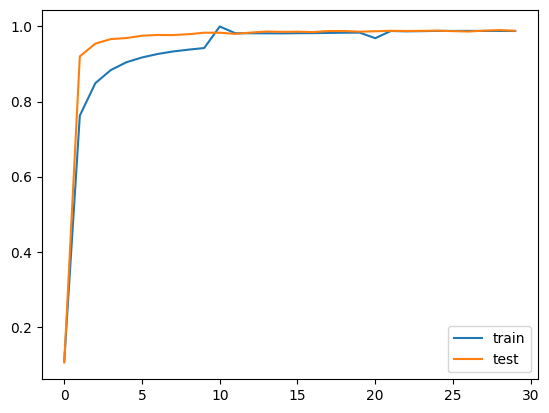

In [22]:
plt.plot(train_finla_acc, label='train')
plt.plot(test_final_acc, label='test')
plt.legend()
plt.show()

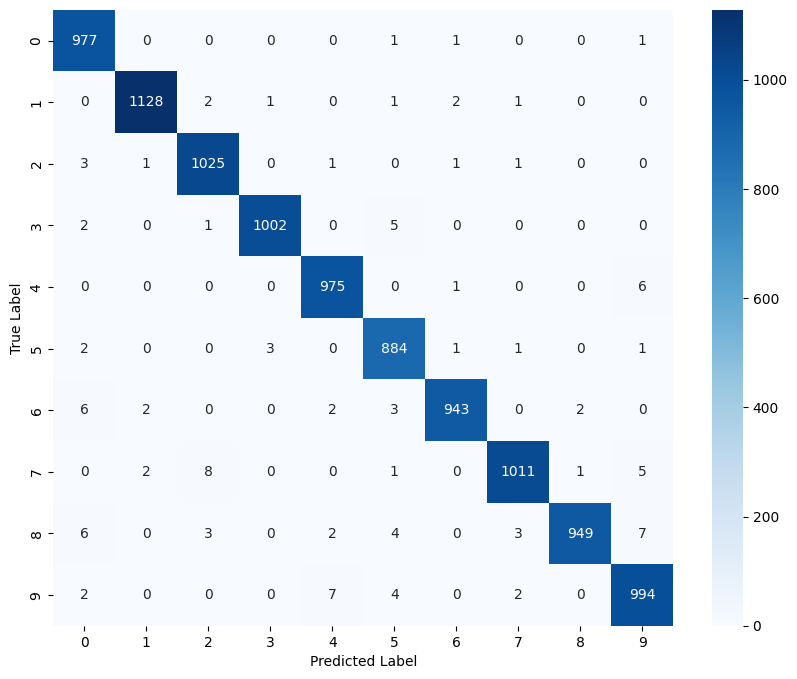

In [25]:
#heatmap
import seaborn as sns
from sklearn.metrics import confusion_matrix
net.eval()
preds = []
labels = []
for (data, target) in test_loader:
    output = net(data) 
    pred = torch.max(output.data, 1)[1] 
    preds.append(pred)
    labels.append(target)
preds = torch.cat(preds, dim=0)
labels = torch.cat(labels, dim=0)
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
